In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.color_palette()
%config InlineBackend.figure_format='retina'

In [3]:
from torchvision.datasets import ImageFolder
train_ds = ImageFolder('../datasets/bm/train')
valid_ds = ImageFolder('../datasets/bm/valid')
test_ds = ImageFolder('../datasets/bm/test')
y_train = np.array([y for _, y in train_ds])
y_valid = np.array([y for _, y in valid_ds])
y_test = np.array([y for _, y in test_ds])
ytvs = y_train, y_valid, y_test

/data/anaconda3/envs/hanliu-tutorial/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
project, group = 'bm_prolific_d512_e50', 'pre_no_aug_0'
results = pd.read_csv(f'results/{project}.{group}.csv')
id_columns = ['agent', 'name', 'model', 'seed']
ts_columns = ['test_clf_acc', 'test_1nn_acc', 'test_triplet_acc']
ds_columns = ['NINO_ds_acc', 'NIFO_ds_acc', 'rNINO_ds_acc']
er_columns = ['NINO_ds_err', 'NIFO_ds_err', 'rNINO_ds_err']
ni_columns = ['NIs', 'NI_acc']
all_columns = id_columns + ts_columns + ds_columns + er_columns + ni_columns

In [5]:
df = results.copy()
df['perf'] = df['test_clf_acc'] + df['test_triplet_acc']
df = df.loc[df.groupby('model')['perf'].idxmax()]
best = {k:int(v) for k, v in zip(df['model'], df['seed'])}
agent = 's'.join(['MTL0', str(best['MTL0'])])
best, agent

({'MTL0': 4, 'MTL0.2': 4, 'MTL0.5': 0, 'MTL0.8': 4, 'MTL1': 4}, 'MTL0s4')

In [6]:
df = results.copy()
for k, v in best.items():
    df = df.drop(df[(df['model']==k) & ~(df['seed'] == v)].index)
df = df.drop(df[(df['agent']=='MTL0') & ~(df['seed'] == best['MTL0'])].index)
df_best = df.copy()
df_agent = results[results['agent'] == agent].copy()
df_agent_best = df_agent.loc[[
    i for i in df_best.index if i in df_agent.index]].copy()
df_agent_best[['name'] + ts_columns]

,name,test_clf_acc,test_1nn_acc,test_triplet_acc
104,MTL0s4,0.600,0.925,0.74750
109,MTL0.2s4,0.950,0.950,0.76125
110,MTL0.5s0,1.000,0.975,0.73250
119,MTL0.8s4,1.000,0.950,0.74125
124,MTL1s4,0.975,0.975,0.63125


In [7]:
def get_ci(samples, confidence=0.95):
    from scipy import stats
    return 2 * stats.sem(samples) * stats.t.ppf((1 + confidence) / 2., len(samples)-1)
df_mean = results.groupby(['agent', 'model']).agg(
    {c: 'mean' for c in ds_columns}).reset_index()
df_sems = results.groupby(['agent', 'model']).agg(
    {c: get_ci for c in ds_columns}).reset_index()
def get_df_mean_sems(df_mean, df_sems, agent=None):
    if agent is not None:
        df_mean = df_mean[df_mean['agent'] == agent]
        df_sems = df_sems[df_sems['agent'] == agent]
    columns = ['NINO_ds_acc', 'NIFO_ds_acc', 'rNINO_ds_acc']
    df_mean_sems = df_mean.copy()
    df_mean_sems[columns] = df_mean[columns].applymap("{:.3f} ± ".format)
    df_mean_sems[columns] += df_sems[columns].applymap("{:.3f}".format)
    return df_mean_sems
get_df_mean_sems(df_mean, df_sems).head()

,agent,model,NINO_ds_acc,NIFO_ds_acc,rNINO_ds_acc
0,MTL0s0,MTL0,0.770 ± 0.119,1.000 ± 0.000,0.815 ± 0.239
1,MTL0s0,MTL0.2,0.795 ± 0.142,1.000 ± 0.000,0.825 ± 0.124
2,MTL0s0,MTL0.5,0.775 ± 0.076,1.000 ± 0.000,0.785 ± 0.083
3,MTL0s0,MTL0.8,0.810 ± 0.094,1.000 ± 0.000,0.805 ± 0.081
4,MTL0s0,MTL1,0.855 ± 0.135,0.860 ± 0.235,0.850 ± 0.088


In [8]:
# for ds in ds_columns:
#     fig, ax = plt.subplots(1, 1, figsize=(10, 4))
#     df = results[id_columns + [ds]].copy()
#     df['agent'] = df['agent'].apply(lambda x: x.split('s')[0] if 'MTL0' in x else x)
#     sns.barplot(ax=ax, x='agent', y=ds, hue='model', data=df)
#     ax.set_ylim((0.5, 1))

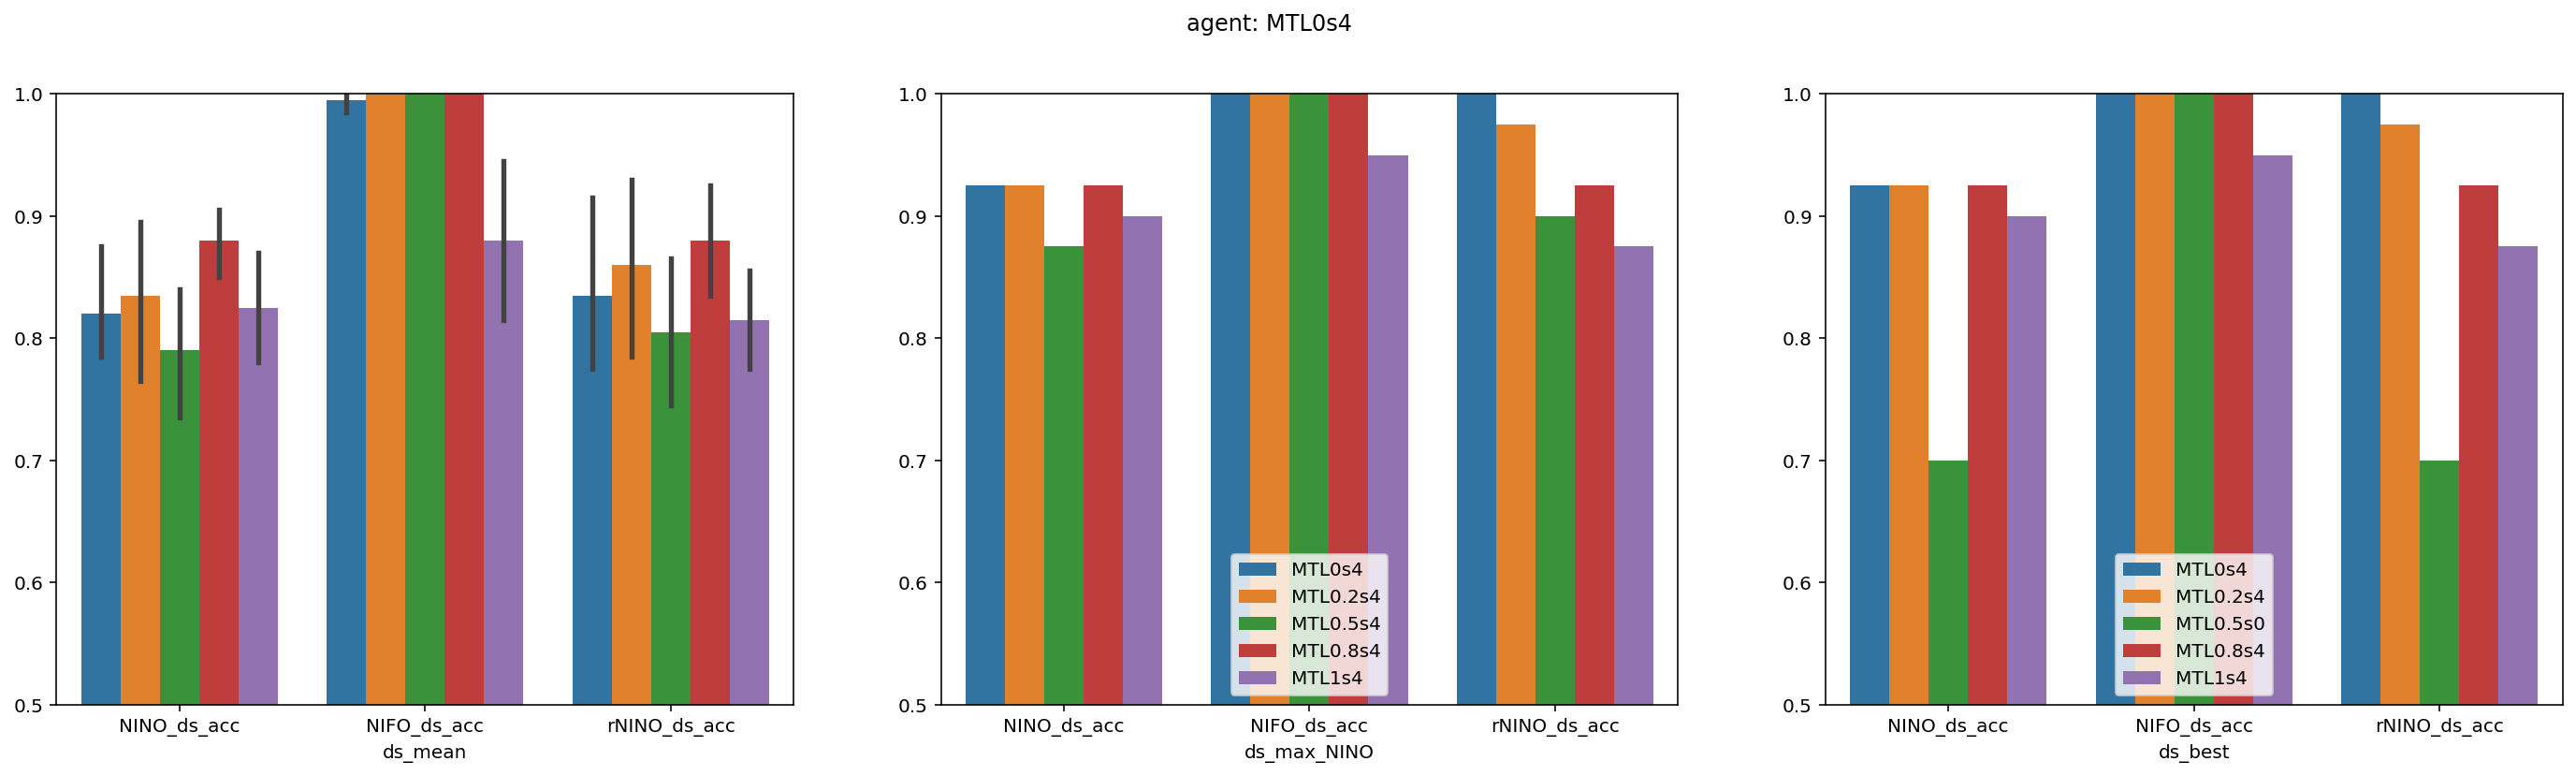

In [9]:
fig, ax = plt.subplots(1, 3, figsize=(24, 6))
fig.suptitle(f"agent: {agent}"); ax[0].set_ylim((0.5, 1))
df_melt = pd.melt(df_agent, id_columns, ds_columns, var_name='ds_mean', value_name='acc')
sns.barplot(ax=ax[0], x='ds_mean', y='acc', hue='model', data=df_melt)
df = df_agent.loc[df_agent.groupby('model')['NINO_ds_acc'].idxmax()]
df_melt = pd.melt(df, id_columns, ds_columns, var_name='ds_max_NINO', value_name='acc')
sns.barplot(ax=ax[1], x='ds_max_NINO', y='acc', hue='name', data=df_melt)
df_melt = pd.melt(df_agent_best, id_columns, ds_columns, var_name='ds_best', value_name='acc')
sns.barplot(ax=ax[2], x='ds_best', y='acc', hue='name', data=df_melt)
_ = [(ax.set_ylim((0.5, 1)), ax.set(ylabel=None), ax.get_legend().remove()) for ax in ax]
ax[1].legend(loc='lower center')
ax[2].legend(loc='lower center')

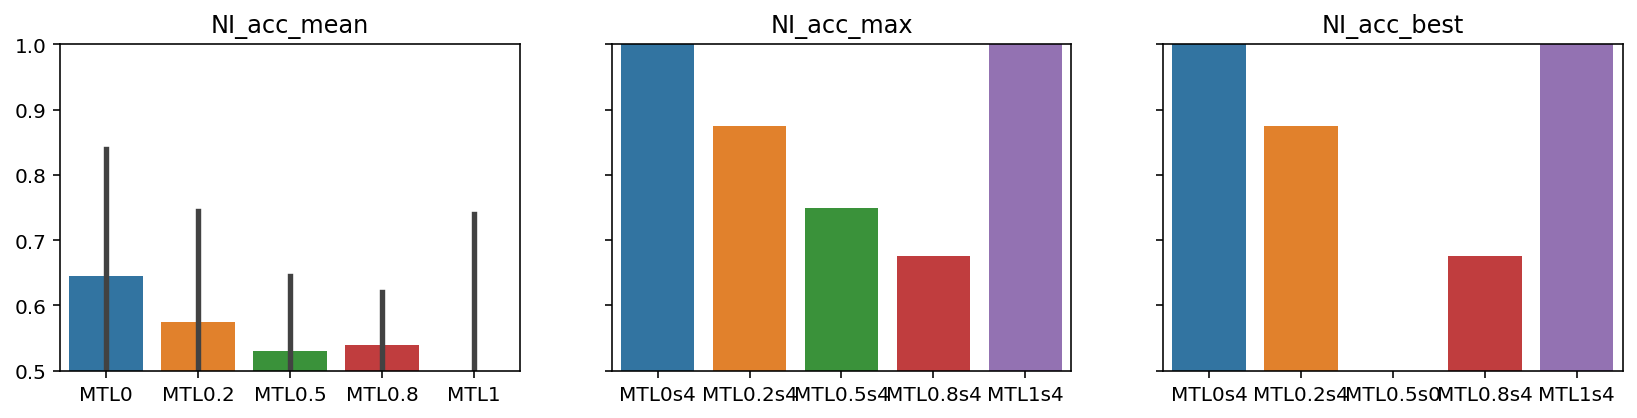

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(14, 3), sharey=True)
df = df_agent[id_columns + ['NI_acc']]
sns.barplot(ax=ax[0], data=df, x='model', y='NI_acc')
df = df_agent[id_columns + ['NI_acc']].loc[df_agent.groupby('model')['NI_acc'].idxmax()]
sns.barplot(ax=ax[1], data=df, x='name', y='NI_acc')
df = df_agent_best[id_columns + ['NI_acc']]
sns.barplot(ax=ax[2], data=df, x='name', y='NI_acc')
titles = ['NI_acc_mean', 'NI_acc_max', 'NI_acc_best']
_ = [(ax.set_ylim((0.5, 1)), ax.set(xlabel=None), ax.set(ylabel=None), ax.set_title(title)) for ax, title in zip(ax, titles)]